In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI
import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime as dt
from tqdm.notebook import tqdm
tqdm.pandas()

In [11]:
# bitcoin = pd.read_csv("../data/raw/bitcoin_3_month.csv")
# btc = pd.read_csv("../data/raw/btc_3_month.csv")
# bitcoin.head()

bitcoin_btc = pd.read_pickle("../data/interim/tweets_verified_2020-2021.pkl")
bitcoin_btc.head()
# bitcoin_btc = bitcoin_btc[:40000]

,created_at,id,conversation_id,user_id,username,name,tweet,language,mentions,urls,...,replies_count,retweets_count,likes_count,hashtags,cashtags,link,quote_url,video,thumbnail,reply_to
0,2020-01-01 00:08:28-05:00,1212239143687741440,1212239143687741440,20646945,dumbfoundead,dumbfoundead.eth,Bitcoin the worst decision i made this decade,en,[],[],...,9,15,409,[],[],https://twitter.com/dumbfoundead/status/121223...,<NA>,False,<NA>,[]
1,2020-01-01 00:54:35-05:00,1212250748815208448,1212250748815208448,636023721,neuroecology,Adam J Calhoun,If you ask someone what they'd do if they went...,en,[],[],...,6,0,4,[],[],https://twitter.com/neuroecology/status/121225...,<NA>,False,<NA>,[]
2,2020-01-01 02:00:25-05:00,1212267316789952512,1212267316789952512,631810714,cnbctv18news,CNBC-TV18,#bitcoin rally begun in 2013 and it reached a ...,en,[],['https://www.cnbctv18.com/market/currency/bit...,...,0,0,4,['bitcoin'],[],https://twitter.com/CNBCTV18News/status/121226...,<NA>,False,<NA>,[]
3,2020-01-01 02:18:48-05:00,1212271940502638593,1212271940502638593,14654494,excellion,Samson Mow,Wishing all #Bitcoin Ultra Enthusiasts a very ...,en,"[{'screen_name': 'blockstream', 'name': 'block...",[],...,10,17,158,"['bitcoin', 'liquidnetwork']",[],https://twitter.com/Excellion/status/121227194...,<NA>,True,https://pbs.twimg.com/media/ENLa5toU0AAvhC1.jpg,[]
4,2020-01-01 02:39:29-05:00,1212277146401402880,1212277146401402880,1066972567943053312,hindustantimes,Hindustan Times,"Breaking down Bitcoin’s 9,000,000% rise in las...",en,[],['http://www.hindustantimes.com/tech/breaking-...,...,0,0,0,[],[],https://twitter.com/HindustanTimes/status/1212...,<NA>,False,<NA>,[]


In [12]:
# # select some column
# bitcoin = bitcoin[['id','date','time','tweet','language','replies_count','retweets_count', 'likes_count']]
# btc = btc[['id','created_at','tweet','language','replies_count','retweets_count', 'likes_count']]
# print(bitcoin.shape)
# print(btc.shape)

# # # drop ADS???
# bitcoin_drop = bitcoin.drop_duplicates(keep=False)
# btc_drop = btc.drop_duplicates(keep=False)
# print(bitcoin_drop.shape)
# print(btc_drop.shape)

# # bitcoin_btc = bitcoin_drop.merge(btc_drop, on='id', how='outer', indicator='btc_status')
# bitcoin_btc  = pd.concat([bitcoin_drop, btc_drop],
#     axis=0,
#     join="outer",
#     ignore_index=False,
#     keys=None,
#     levels=None,
#     names=None,
#     verify_integrity=False,
#     copy=False,
# )
# bitcoin_btc = bitcoin_btc.drop_duplicates(subset='id')
# print(bitcoin_btc.shape)
# bitcoin_btc

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chayisara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# language EN only
df = bitcoin_btc[bitcoin_btc['language'] == 'en'].reset_index()
print(df["tweet"].shape)

(312204,)


In [15]:
# apply all lower case
df_lower = pd.DataFrame(df["tweet"].str.lower())

def clean_tweet_1(tweet):
    # remove URL "https://t.co/"
    new_url = re.sub(r"https://t.co/[A-Za-z0-9]+", " ", tweet)
    
    # remove mention
    new_mention = re.sub(r"@[A-Za-z0-9!#%&*;_\$\.]+", " ", new_url)
    
    return new_mention
    
def clean_tweet_2(tweet):
    # remove # ,turning hashtags to the typical words.
    new_symbol = re.sub(r"\W+", " ", tweet)
    
    return new_symbol

def repl(matchObj):
    char = matchObj.group(1)
    return "%s%s" % (char, char)

def clean_tweet_3(tweet):
    # reduce character sequences >3 to 3
    new_sequence = re.sub(re.compile(r"(\w)\1+"), repl, tweet)

    # remove 2-character words
    new_twochar = re.sub(r"\b[a-z]{1,2}\b", " ", new_sequence)
    
    # replace 2 or more spaces with a single space.
    new_space = re.sub(r"\s+", " ", new_twochar)
    
    # remove spaces front and back
    new_space_end = re.sub(r"^\s+|\s$", "", new_space)
    
    return new_space_end

df_lower['tweet'] = df_lower['tweet'].apply(clean_tweet_1)
all_money = df_lower['tweet']
    
# remove URL "https://t.co/"
# new_url = [re.sub(r"https://t.co/[A-Za-z0-9]+", " ", tweet) for tweet in df_lower.tweet]
# remove mention
# new_mention = [re.sub(r"@[A-Za-z0-9!#%&*;_\$\.]+", " ", tweet) for tweet in new_url]

In [16]:
# for i in new_mention:
#     spacy_tweet = nlp(i)
# #     print(type(spacy_tweet))
#     for one_tok in spacy_tweet.ents:
#         print("Entity: " + one_tok.text + "; NER tag: " + one_tok.label_)

In [17]:
# remove # ,turning hashtags to the typical words.
# new_symbol = [re.sub(r"\W+", " ", tweet) for tweet in new_mention]
df_lower['tweet'] = df_lower['tweet'].apply(clean_tweet_2)
df_lower['tweet']

0             bitcoin the worst decision i made this decade
1         if you ask someone what they d do if they went...
2          bitcoin rally begun in 2013 and it reached a ...
3         wishing all bitcoin ultra enthusiasts a very h...
4         breaking down bitcoin s 9 000 000 rise in last...
                                ...                        
312199                                         fair enough 
312200                              happy new year bitcoin 
312201     buy bitcoin amp chill defund the political pa...
312202      bitcoin faces uncertain 2022 after record year 
312203    you re a great example to our fellow bitcoin f...
Name: tweet, Length: 312204, dtype: object

In [18]:
# remove stopword
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

df_lower['tweet'] = remove_stop_words(df_lower['tweet'])

In [19]:
df_lower['tweet'] = df_lower['tweet'].apply(clean_tweet_3)
df_lower['tweet']

0                        bitcoin worst decision made decade
1         ask someone went back ten years use informatio...
2          bitcoin rally begun 2013 reached peak 20 00 2017
3         wishing bitcoin ultra enthusiasts happy new ye...
4         breaking bitcoin 9 00 00 rise last decade left...
                                ...                        
312199                                          fair enough
312200                               happy new year bitcoin
312201     buy bitcoin amp chill defund political parasites
312202             bitcoin faces uncertain 2022 record year
312203         great example fellow bitcoin familia brother
Name: tweet, Length: 312204, dtype: object

In [20]:
# # reduce character sequences >3 to 3
# sequence_pattern = re.compile(r"(\w)\1+")
# def repl(matchObj):
#    char = matchObj.group(1)
#    return "%s%s" % (char, char)

# new_sequence = [re.sub(sequence_pattern, repl, tweet) for tweet in new_stopwords]

In [21]:
# # remove 2-character words
# new_twochar = [re.sub(r"\b[a-z]{1,2}\b", " ", tweet) for tweet in new_symbol]

# # replace 2 or more spaces with a single space.
# new_space = [re.sub(r"\s+", " ", tweet) for tweet in new_sequence]

# # remove spaces front and back
# new_space_end = [re.sub(r"^\s+|\s$", "", tweet) for tweet in new_space]
# new_space_end[4]

In [23]:
sent_obj = SentimentIntensityAnalyzer()
print(type(sent_obj))

sent_data = df_lower['tweet']
sentiment_example = []
for i in sent_data:
    sentiment_example.append(sent_obj.polarity_scores(i))

<class 'vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer'>


In [24]:
# sent_obj.lexicon
neg = [sent_obj.lexicon[k] for k in sent_obj.lexicon if sent_obj.lexicon[k] < 0]
np.mean(neg)
pos = [sent_obj.lexicon[k] for k in sent_obj.lexicon if sent_obj.lexicon[k] > 0]
np.mean(pos)

# sent_obj.lexicon['']

-1.552026864955625

1.5321845969433623

In [25]:
pest_words = {
    'up': 2.0,
    'down': -2.0,
    'green' : 2.0,
    'red' : -2.0,
    'bull' : 2.0,
    'bear' : -2.0,
    'buy' : 2.0,
    'bought' : 2.0,
    'sell' : -2.0,
    'sold' : -2.0,
    'moon': 2
}

new_si = SentimentIntensityAnalyzer()
new_si.lexicon.update(pest_words)

sentiment_update = []
for i in sent_data:
    sentiment_update.append(sent_obj.polarity_scores(i))
sentiment_update

[{'neg': 0.506, 'neu': 0.494, 'pos': 0.0, 'compound': -0.6249},
 {'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'compound': 0.3612},
 {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.1027},
 {'neg': 0.0, 'neu': 0.605, 'pos': 0.395, 'compound': 0.9136},
 {'neg': 0.323, 'neu': 0.677, 'pos': 0.0, 'compound': -0.5106},
 {'neg': 0.323, 'neu': 0.677, 'pos': 0.0, 'compound': -0.5106},
 {'neg': 0.242, 'neu': 0.59, 'pos': 0.169, 'compound': -0.3818},
 {'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'compound': 0.4215},
 {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263},
 {'neg': 0.183, 'neu': 0.57, 'pos': 0.247, 'compound': 0.4019},
 {'neg': 0.0, 'neu': 0.619, 'pos': 0.381, 'compound': 0.5719},
 {'neg': 0.0, 'neu': 0.634, 'pos': 0.366, 'compound': 0.9022},
 {'neg': 0.202, 'neu': 0.534, 'pos': 0.263, 'compound': 0.3818},
 {'neg': 0.381, 'neu': 0.619, 'pos': 0.0, 'compound': -0.5106},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound'

In [26]:
all_compound = [one_tok['compound'] for one_tok in sentiment_update]
temp = pd.DataFrame(all_compound)
df['compound'] = temp
df[['tweet', 'compound']]

,tweet,compound
0,Bitcoin the worst decision i made this decade,-0.6249
1,If you ask someone what they'd do if they went...,0.3612
2,#bitcoin rally begun in 2013 and it reached a ...,0.1027
3,Wishing all #Bitcoin Ultra Enthusiasts a very ...,0.9136
4,"Breaking down Bitcoin’s 9,000,000% rise in las...",-0.5106
...,...,...
312199,@Bitcoin__art Fair enough 😅😅😅,0.3182
312200,Happy New Year #Bitcoin https://t.co/HdUQNDKUUA,0.5719
312201,"@rubiconcapital_ Buy bitcoin &amp; chill, defu...",0.0000
312202,Bitcoin faces uncertain 2022 after record year...,-0.2960


In [27]:
# weight retweet
df['compound'] = df['compound'].astype(float)
compound_weight = []
def get_weight_score(row):
    famous_score = row['replies_count']*1/3 + row['retweets_count']*1/3 + row['likes_count']*1/3
    if (famous_score < 50):
        compound_weight.append(row['compound'])
    elif (famous_score > 50) and (famous_score < 200):
        compound_weight.append(row['compound']*2)
    elif (famous_score > 200) and (famous_score < 500):
        compound_weight.append(row['compound']*4)
    elif (famous_score > 500) and (famous_score < 999):
        compound_weight.append(row['compound']*8)
    elif (famous_score > 1000) and (famous_score < 3000):
        compound_weight.append(row['compound']*16)
    elif (famous_score > 3000) and (famous_score < 9999):
        compound_weight.append(row['compound']*32)
    else:
        compound_weight.append(row['compound']*64)

df.apply(get_weight_score, axis=1)
df['compound_weight'] = compound_weight
df['compound_weight'] 

0         None
1         None
2         None
3         None
4         None
          ... 
312199    None
312200    None
312201    None
312202    None
312203    None
Length: 312204, dtype: object

0        -1.2498
1         0.3612
2         0.1027
3         1.8272
4        -0.5106
           ...  
312199    0.3182
312200    0.5719
312201    0.0000
312202   -0.2960
312203    0.6249
Name: compound_weight, Length: 312204, dtype: float64

In [28]:
# # create date-time column
df_bydate = df.groupby(df['created_at'].dt.date).agg({"compound_weight" : "mean"}).reset_index()
df_bydate

,created_at,compound_weight
0,2020-01-01,0.293511
1,2020-01-02,0.082999
2,2020-01-03,0.318430
3,2020-01-04,0.151216
4,2020-01-05,0.197179
...,...,...
726,2021-12-27,0.354869
727,2021-12-28,0.736014
728,2021-12-29,0.263871
729,2021-12-30,0.423931


ConversionError: Failed to convert value(s) to axis units: '2020-01-01'

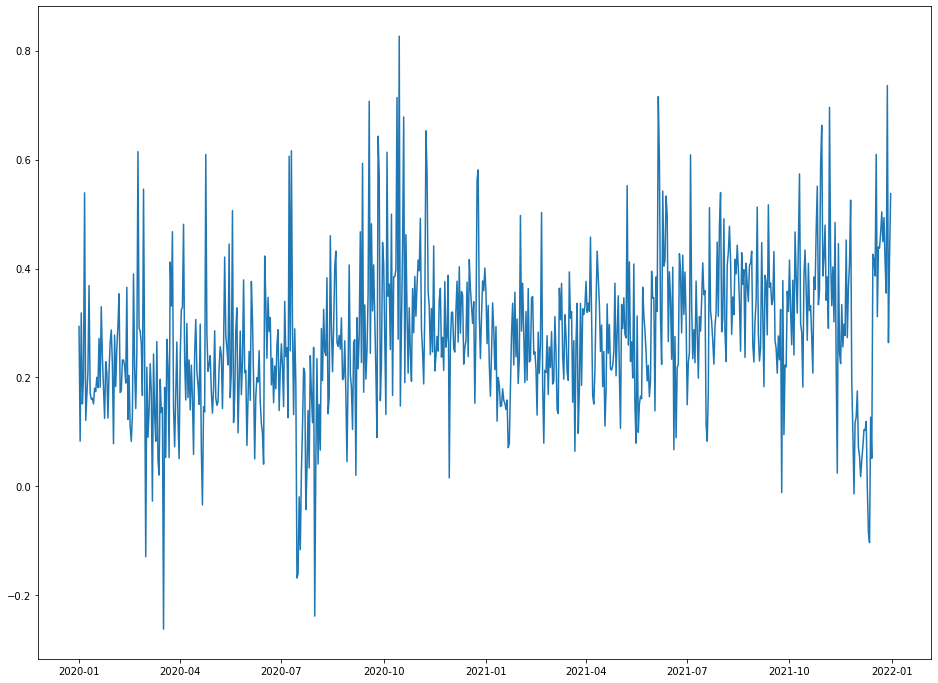

In [33]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.plot(df_bydate['created_at'], df_bydate['compound_weight'])
ax.set_xlim(["2020-01-01", "2020-12-31"])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Compound Weight")

plt.show()

In [ ]:
# Stremming ex hom/home/homey
# group compound words
# word mattrix??
# add stopwords

In [ ]:
def get_money(one_string):
    
    tagged_str = nlp(one_string) 
    all_money = [one_tok.text for one_tok in tagged_str.ents 
                  if one_tok.label_ == "MONEY"]
    return(all_money)

all_money = all_money.progress_apply(get_money)

In [ ]:
for i in all_money:
    for j in i: 
        if (j > '30000') or (j < '100000'):
            print()
        
all_money